In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy

pd.set_option('display.max_columns', 500)

In [2]:
BALL_VARS = ['ballx', 'bally']
HOME_VARS = ['p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x', 'p4y', 'p5x', 'p5y', 'p6x', 'p6y', 'p7x', 'p7y', 'p8x', 'p8y', 'p9x', 'p9y', 'p10x', 'p10y', 'p11x', 'p11y']
AWAY_VARS = ['p12x', 'p12y', 'p13x', 'p13y', 'p14x', 'p14y', 'p15x', 'p15y', 'p16x', 'p16y', 'p17x', 'p17y', 'p18x', 'p18y', 'p19x', 'p19y', 'p20x', 'p20y', 'p21x', 'p21y', 'p22x', 'p22y']
FRAME_VARS = [f.replace('x', 'dx').replace('y', 'dy') for f in BALL_VARS] + [f.replace('x', 'dx').replace('y', 'dy') for f in HOME_VARS] + [f.replace('x', 'dx').replace('y', 'dy') for f in AWAY_VARS]
CONTEXT_VARS = BALL_VARS + HOME_VARS + AWAY_VARS

In [3]:
N_CONTEXT_FRAMES = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading data

In [4]:
data = pd.read_feather('data/tracking2.feather')

In [ ]:
features = ['playDirection']
# add context vars
i = 1
data_context = data.shift(i)
data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
data_context = data_context[CONTEXT_VARS].add_prefix(f'c{i}_')
data = pd.concat([data, data_context], axis=1)
features += list(data_context.columns)
# add frame vars
for i in range(1, N_CONTEXT_FRAMES + 1):
    data_context = data.shift(i)
    data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
    data_context = data_context[FRAME_VARS].add_prefix(f'c{i}_')
    data = pd.concat([data, data_context], axis=1)
    features += list(data_context.columns)

data = data.dropna()

In [6]:
data

,gameId,playId,frameId,is_after_snap,playDirection,ballx,bally,balldx,balldy,p1x,p1y,p1dx,p1dy,p2x,p2y,p2dx,p2dy,p3x,p3y,p3dx,p3dy,p4x,p4y,p4dx,p4dy,p5x,p5y,p5dx,p5dy,p6x,p6y,p6dx,p6dy,p7x,p7y,p7dx,p7dy,p8x,p8y,p8dx,p8dy,p9x,p9y,p9dx,p9dy,p10x,p10y,p10dx,p10dy,p11x,p11y,p11dx,p11dy,p12x,p12y,p12dx,p12dy,p13x,p13y,p13dx,p13dy,p14x,p14y,p14dx,p14dy,p15x,p15y,p15dx,p15dy,p16x,p16y,p16dx,p16dy,p17x,p17y,p17dx,p17dy,p18x,p18y,p18dx,p18dy,p19x,p19y,p19dx,p19dy,p20x,p20y,p20dx,p20dy,p21x,p21y,p21dx,p21dy,p22x,p22y,p22dx,p22dy,c1_ballx,c1_bally,c1_p1x,c1_p1y,c1_p2x,c1_p2y,c1_p3x,c1_p3y,c1_p4x,c1_p4y,c1_p5x,c1_p5y,c1_p6x,c1_p6y,c1_p7x,c1_p7y,c1_p8x,c1_p8y,c1_p9x,c1_p9y,c1_p10x,c1_p10y,c1_p11x,c1_p11y,c1_p12x,c1_p12y,c1_p13x,c1_p13y,c1_p14x,c1_p14y,c1_p15x,c1_p15y,c1_p16x,c1_p16y,c1_p17x,c1_p17y,c1_p18x,c1_p18y,c1_p19x,c1_p19y,c1_p20x,c1_p20y,c1_p21x,c1_p21y,c1_p22x,c1_p22y,c1_balldx,c1_balldy,c1_p1dx,c1_p1dy,c1_p2dx,c1_p2dy,c1_p3dx,c1_p3dy,c1_p4dx,c1_p4dy,c1_p5dx,c1_p5dy,c1_p6dx,c1_p6dy,c1_p7dx,c1_p7dy,c1_p8dx,c1_p8dy,c1_p9dx,c1_p9dy,c1_p10dx,c1_p10dy,c1_p11dx,c1_p11dy,c1_p12dx,c1_p12dy,c1_p13dx,c1_p13dy,c1_p14dx,c1_p14dy,c1_p15dx,c1_p15dy,c1_p16dx,c1_p16dy,c1_p17dx,c1_p17dy,c1_p18dx,c1_p18dy,c1_p19dx,c1_p19dy,c1_p20dx,c1_p20dy,c1_p21dx,c1_p21dy,c1_p22dx,c1_p22dy
2,2022090800,56,3,False,0,0.710000,0.556098,-0.000083,0.000000,0.744000,0.553846,-0.000917,0.000188,0.736500,0.565103,-0.001750,-0.000563,0.758667,0.522326,-0.000167,-0.004690,0.745833,0.539587,-0.000917,-0.000938,0.753333,0.543902,-0.000417,-0.003752,0.757833,0.550657,0.000250,0.000375,0.763917,0.533208,0.000083,-0.002064,0.750667,0.616510,-0.001167,0.003002,0.740250,0.583490,-0.001417,0.000750,0.769750,0.520450,0.000500,-0.006567,0.746917,0.593621,-0.001500,0.001501,0.681083,0.537711,-0.000833,0.001313,0.690000,0.561914,-0.000417,0.001126,0.682417,0.458349,-0.000667,-0.001501,0.679000,0.618386,-0.000500,0.003189,0.691750,0.615760,-0.000167,0.002064,0.699000,0.547280,0.000000,0.000563,0.674250,0.472233,-0.000333,-0.002627,0.687333,0.545591,-0.000250,0.000563,0.667333,0.507505,-0.001167,-0.001313,0.664833,0.617636,-0.000667,0.002439,0.678500,0.567355,-0.000750,0.001126,0.710083,0.556098,0.744917,0.553659,0.738250,0.565666,0.758833,0.527017,0.746750,0.540525,0.753750,0.547655,0.757583,0.550281,0.763833,0.535272,0.751833,0.613508,0.741667,0.582739,0.769250,0.527017,0.748417,0.592120,0.681917,0.536398,0.690417,0.560788,0.683083,0.459850,0.679500,0.615197,0.691917,0.613696,0.699000,0.546717,0.674583,0.474859,0.687583,0.545028,0.668500,0.508818,0.665500,0.615197,0.679250,0.566229,0.000000,0.000000,-0.000750,-0.000188,-0.001750,-0.000750,-0.000167,-0.004690,-0.000917,-0.001126,-0.000417,-0.003752,0.000250,0.000375,0.000167,-0.001876,-0.001167,0.003002,-0.001417,0.000750,0.000500,-0.006191,-0.001250,0.001313,-0.000833,0.001313,-0.000417,0.000938,-0.000667,-0.001501,-0.000500,0.003377,-0.000167,0.002064,0.000083,0.000750,-0.000417,-0.002439,-0.000333,0.000375,-0.001083,-0.001126,-0.000667,0.002439,-0.000583,0.001501
3,2022090800,56,4,False,0,0.710000,0.556098,0.000000,0.000000,0.742917,0.553846,-0.001083,0.000000,0.734833,0.564353,-0.001667,-0.000750,0.758417,0.517824,-0.000250,-0.004503,0.744917,0.538837,-0.000917,-0.000750,0.752917,0.539775,-0.000417,-0.004128,0.758250,0.551407,0.000417,0.000750,0.764083,0.531332,0.000167,-0.001876,0.749500,0.619512,-0.001167,0.003002,0.738667,0.584240,-0.001583,0.000750,0.770083,0.513321,0.000333,-0.007129,0.745333,0.595497,-0.001583,0.001876,0.680167,0.538837,-0.000917,0.001126,0.689750,0.563227,-0.000250,0.001313,0.681750,0.456660,-0.000667,-0.001689,0.678417,0.621764,-0.000583,0.003377,0.691667,0.617824,-0.000083,0.002064,0.699000,0.548030,0.000000,0.000750,0.673917,0.469794,-0.000333,-0.002439,0.687250,0.546154,-0.000083,0.000563,0.666167,0.506191,-0.001167,-0.001313,0.664250,0.620075,-0.000583,0.002439,0.677750,0.568480,-0.000750,0.001126,0.710000,0.556098,0.744000,0.553846,0.736500,0.565103,0.758667,0.522326,0.745833,0.539587,0.753333,0.54390

In [7]:
data = data[data['is_after_snap'] == True]

In [23]:
print(features, len(features))

['playDirection', 'c1_ballx', 'c1_bally', 'c1_p1x', 'c1_p1y', 'c1_p2x', 'c1_p2y', 'c1_p3x', 'c1_p3y', 'c1_p4x', 'c1_p4y', 'c1_p5x', 'c1_p5y', 'c1_p6x', 'c1_p6y', 'c1_p7x', 'c1_p7y', 'c1_p8x', 'c1_p8y', 'c1_p9x', 'c1_p9y', 'c1_p10x', 'c1_p10y', 'c1_p11x', 'c1_p11y', 'c1_p12x', 'c1_p12y', 'c1_p13x', 'c1_p13y', 'c1_p14x', 'c1_p14y', 'c1_p15x', 'c1_p15y', 'c1_p16x', 'c1_p16y', 'c1_p17x', 'c1_p17y', 'c1_p18x', 'c1_p18y', 'c1_p19x', 'c1_p19y', 'c1_p20x', 'c1_p20y', 'c1_p21x', 'c1_p21y', 'c1_p22x', 'c1_p22y', 'c1_balldx', 'c1_balldy', 'c1_p1dx', 'c1_p1dy', 'c1_p2dx', 'c1_p2dy', 'c1_p3dx', 'c1_p3dy', 'c1_p4dx', 'c1_p4dy', 'c1_p5dx', 'c1_p5dy', 'c1_p6dx', 'c1_p6dy', 'c1_p7dx', 'c1_p7dy', 'c1_p8dx', 'c1_p8dy', 'c1_p9dx', 'c1_p9dy', 'c1_p10dx', 'c1_p10dy', 'c1_p11dx', 'c1_p11dy', 'c1_p12dx', 'c1_p12dy', 'c1_p13dx', 'c1_p13dy', 'c1_p14dx', 'c1_p14dy', 'c1_p15dx', 'c1_p15dy', 'c1_p16dx', 'c1_p16dy', 'c1_p17dx', 'c1_p17dy', 'c1_p18dx', 'c1_p18dy', 'c1_p19dx', 'c1_p19dy', 'c1_p20dx', 'c1_p20dy', 'c1_

In [9]:
train_data = data[data['gameId'] < 2022101700]
val_data = data[(data['gameId'] >= 2022101700) & (data['gameId'] < 2022102400)]
test_data = data[data['gameId'] >= 2022102400]

# Modeling

In [10]:
# MDN Model Definition
class MDN(nn.Module):
    def __init__(self, input_dim, n_points, n_gaussians):
        super(MDN, self).__init__()

        self.n_points = n_points
        self.n_gaussians = n_gaussians

        self.fc1 = nn.Linear(input_dim, 1024)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc_mu = nn.Linear(1024, n_points * n_gaussians * 2)   # Means
        self.fc_sigma = nn.Linear(1024, n_points * n_gaussians * 2) # Std deviations
        self.fc_pi = nn.Linear(1024, n_points * n_gaussians)        # Mixture weights

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        mu = self.fc_mu(x).view(-1, self.n_points, self.n_gaussians, 2)
        sigma = F.softplus(self.fc_sigma(x)).view(-1, self.n_points, self.n_gaussians, 2)# + 1e-6
        pi = torch.softmax(self.fc_pi(x).view(-1, self.n_points, self.n_gaussians), dim=-1)
        return mu, sigma, pi

# Loss function
def mdn_nll_loss(y, mu, sigma, pi):
    m = dist.Normal(mu, sigma)
    log_prob = m.log_prob(y.unsqueeze(2))  # Add Gaussian components dimension
    log_prob = torch.sum(log_prob, dim=-1) # Sum over x and y dimensions
    weighted_log_prob = log_prob + torch.log(pi)
    nll = -torch.logsumexp(weighted_log_prob, dim=-1)  # Log-sum-exp over gaussians
    return nll.mean()

# Sampling function
def sample_from_mdn(mu, sigma, pi, n_samples=1):
    batch_size, n_points, n_gaussians, _ = mu.shape
    samples = []

    for b in range(batch_size):
        point_samples = []
        for p in range(n_points):
            # Sample component
            categorical = dist.Categorical(pi[b, p])
            component = categorical.sample((n_samples,))
            
            # Sample from Gaussian
            chosen_mu = mu[b, p, component, :]
            chosen_sigma = sigma[b, p, component, :]

            # Check if elements in chosen_sigma are close to zero
            is_sigma_zero = torch.isclose(chosen_sigma, torch.zeros_like(chosen_sigma))
            
            # Set sigma to 1 temporarily where it's close to zero to avoid errors during sampling
            safe_sigma = torch.where(is_sigma_zero, torch.ones_like(chosen_sigma), chosen_sigma)
            
            # Sample from Normal distribution with safe_sigma
            normal_dist = dist.Normal(chosen_mu, safe_sigma)
            samples_for_point = normal_dist.sample()
            
            # Replace values where sigma was originally close to zero with mean
            samples_for_point = torch.where(is_sigma_zero, chosen_mu, samples_for_point)
            
            point_samples.append(samples_for_point)

        samples.append(torch.stack(point_samples).squeeze(1))
    
    return torch.stack(samples)  # Shape: (batch_size, n_points, n_samples, 2)

In [11]:
# Parameters
n_points = 23 # 23 elements on the field
input_dim = len(features)
n_gaussians = 3 # Number of mixture components
output_dim = 11 * 2 * 2 * n_gaussians # 11 players * 2 teams * 2 coordinates * n_gaussians per point

In [12]:
x_train = torch.tensor(train_data[features].values, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(train_data[FRAME_VARS].values, dtype=torch.float32).view(-1, n_points, 2).to(DEVICE)
x_val = torch.tensor(val_data[features].values, dtype=torch.float32).to(DEVICE)
y_val = torch.tensor(val_data[FRAME_VARS].values, dtype=torch.float32).view(-1, n_points, 2).to(DEVICE)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [13]:
# Training the model
model = MDN(input_dim=input_dim, n_points=n_points, n_gaussians=n_gaussians).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 25

In [14]:
for epoch in range(n_epochs):
    for x_train, y_train in tqdm(train_loader):
        optimizer.zero_grad()
        mu, sigma, pi = model(x_train)
        loss = mdn_nll_loss(y_train, mu, sigma, pi)
        loss.backward()
        optimizer.step()
        
    if ((epoch % 1)) == 0:
        val_loss = 0
        for x_val, y_val in val_loader:
            mu, sigma, pi = model(x_val)
            val_loss += mdn_nll_loss(y_val, mu, sigma, pi).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

100%|██████████| 591/591 [00:05<00:00, 103.50it/s]


Epoch 0, Loss: -7.3416, Val Loss: -7.5339


100%|██████████| 591/591 [00:05<00:00, 107.73it/s]


Epoch 1, Loss: -8.3431, Val Loss: -7.9634


100%|██████████| 591/591 [00:05<00:00, 109.04it/s]


Epoch 2, Loss: -8.8048, Val Loss: -8.7690


100%|██████████| 591/591 [00:05<00:00, 105.36it/s]


Epoch 3, Loss: -8.9406, Val Loss: -8.8925


100%|██████████| 591/591 [00:05<00:00, 106.47it/s]


Epoch 4, Loss: -9.0841, Val Loss: -9.0427


100%|██████████| 591/591 [00:05<00:00, 107.57it/s]


Epoch 5, Loss: -9.2363, Val Loss: -9.0523


100%|██████████| 591/591 [00:05<00:00, 107.42it/s]


Epoch 6, Loss: -9.2296, Val Loss: -9.3416


100%|██████████| 591/591 [00:05<00:00, 105.51it/s]


Epoch 7, Loss: -9.1935, Val Loss: -9.3370


100%|██████████| 591/591 [00:05<00:00, 105.95it/s]


Epoch 8, Loss: -9.2189, Val Loss: -9.4296


100%|██████████| 591/591 [00:05<00:00, 107.51it/s]


Epoch 9, Loss: -8.4574, Val Loss: -8.5555


100%|██████████| 591/591 [00:05<00:00, 105.29it/s]


Epoch 10, Loss: -8.9029, Val Loss: -8.8965


100%|██████████| 591/591 [00:05<00:00, 109.38it/s]


Epoch 11, Loss: -8.9754, Val Loss: -8.9857


100%|██████████| 591/591 [00:05<00:00, 107.22it/s]


Epoch 12, Loss: -8.1882, Val Loss: -8.0963


100%|██████████| 591/591 [00:05<00:00, 108.84it/s]


Epoch 13, Loss: -9.1564, Val Loss: -9.1542


100%|██████████| 591/591 [00:05<00:00, 104.69it/s]


Epoch 14, Loss: -9.0558, Val Loss: -8.7156


100%|██████████| 591/591 [00:05<00:00, 107.02it/s]


Epoch 15, Loss: -9.2638, Val Loss: -9.2650


100%|██████████| 591/591 [00:05<00:00, 107.02it/s]


Epoch 16, Loss: -9.3224, Val Loss: -9.3554


100%|██████████| 591/591 [00:05<00:00, 102.65it/s]


Epoch 17, Loss: -9.4313, Val Loss: -9.3990


100%|██████████| 591/591 [00:05<00:00, 104.01it/s]


Epoch 18, Loss: -9.3794, Val Loss: -9.3149


100%|██████████| 591/591 [00:05<00:00, 107.42it/s]


Epoch 19, Loss: -9.2901, Val Loss: -9.2782


100%|██████████| 591/591 [00:05<00:00, 107.13it/s]


Epoch 20, Loss: -9.4513, Val Loss: -9.3408


100%|██████████| 591/591 [00:05<00:00, 104.92it/s]


Epoch 21, Loss: -9.5921, Val Loss: -9.5040


100%|██████████| 591/591 [00:05<00:00, 107.20it/s]


Epoch 22, Loss: -9.5302, Val Loss: -9.4935


100%|██████████| 591/591 [00:05<00:00, 107.04it/s]


Epoch 23, Loss: -9.5541, Val Loss: -9.5622


100%|██████████| 591/591 [00:05<00:00, 107.58it/s]


Epoch 24, Loss: -9.5643, Val Loss: -9.5827


# Plotting

In [66]:
play_data = val_data[(val_data['gameId'] == 2022101700) & (val_data['playId'] == 90)]
play_data.shape, play_data['playDirection'].iloc[0]

((53, 189), np.int64(0))

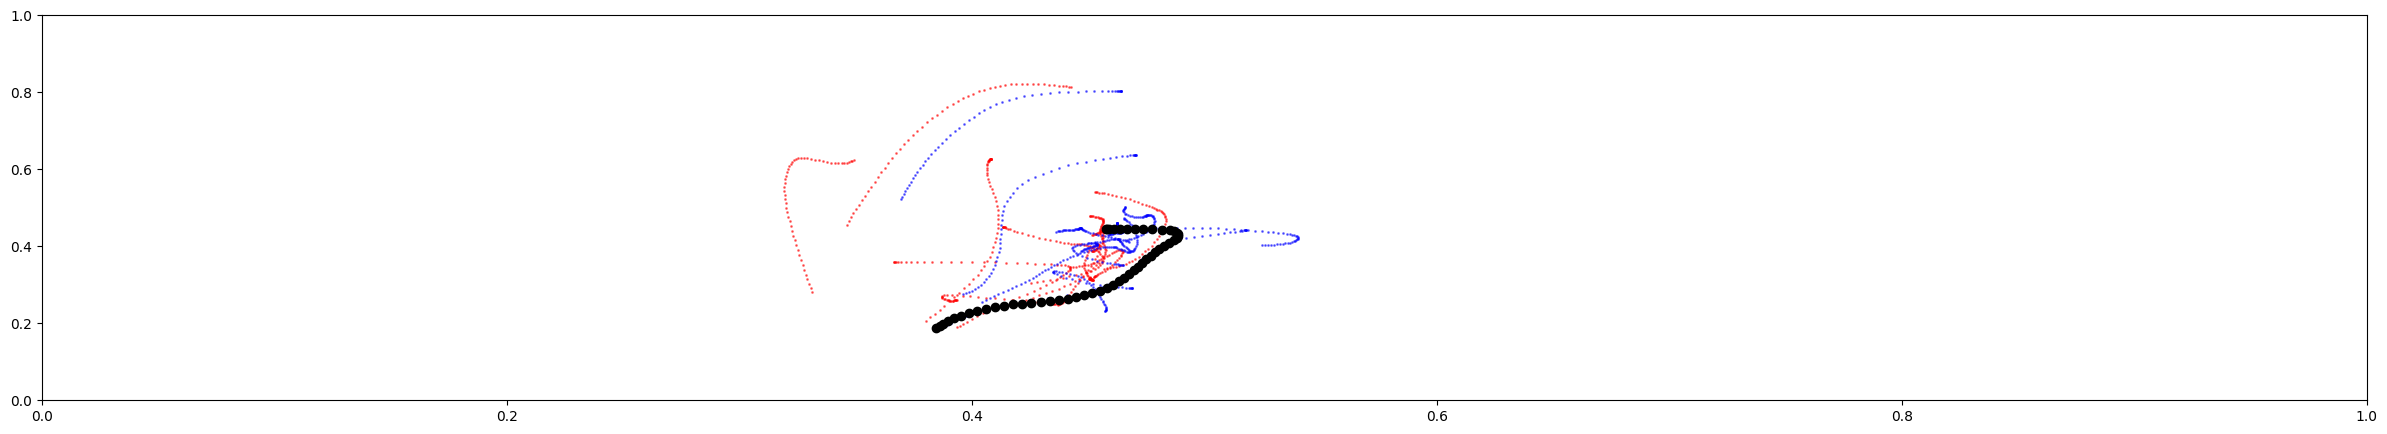

In [63]:
for i in range(1, 23):
    plt.plot(play_data[f'p{i}x'], play_data[f'p{i}y'], '.', color='red' if i <= 11 else 'blue', markersize=2, alpha=0.5)
plt.plot(play_data['ballx'], play_data['bally'], 'o', color='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [64]:
frames = []

current_frame = play_data.iloc[0][features].values.tolist()
for i in tqdm(range(play_data.shape[0])):
    x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
    mu, sigma, pi = model(x)
    samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()
    # Sum the sample with the current frame to get the next frame
    current_frame[1:n_points * 2 + 1] += samples.flatten()
    # shift the context frames
    current_frame = np.concat([current_frame[:n_points * 2 + 1], samples.flatten(), current_frame[2 * n_points * 2 + 1:]])
    frames.append(current_frame[1:n_points * 2 + 1])
    
frames = pd.DataFrame(frames, columns=CONTEXT_VARS)

100%|██████████| 53/53 [00:01<00:00, 26.70it/s]


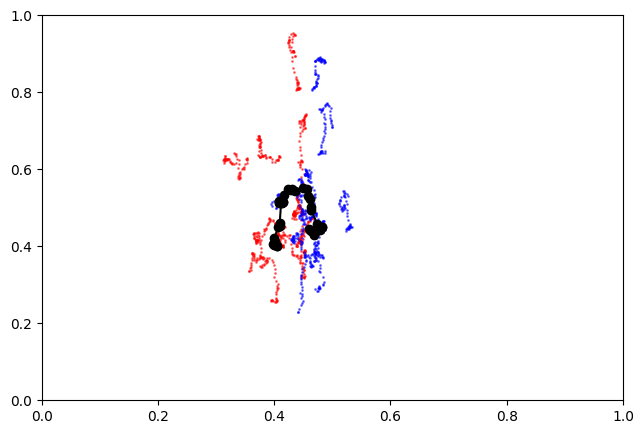

In [147]:
plt.rcParams['figure.figsize'] = [7.5, 5]
for i in range(1, 23):
    plt.plot(frames[f'p{i}x'], frames[f'p{i}y'], '.', color='red' if i <= 11 else 'blue', markersize=2, alpha=0.5)
plt.plot(frames['ballx'], frames['bally'], color='black', marker='o')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [139]:
ball_positions_in_lookahead = {}
max_lookahead = 70

current_frame = play_data.iloc[0][features].values.tolist()
current_frame = [current_frame for _ in range(100)]
x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE)
for i in tqdm(range(max_lookahead + 1)):
    mu, sigma, pi = model(x)
    samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()
    samples = torch.tensor([sample.flatten() for sample in samples], dtype=torch.float32).to(DEVICE)
    x[:, 1:n_points * 2 + 1] += samples
    x = torch.concat([x[:, :n_points * 2 + 1], samples], axis=1)

    if (i % 10 == 0) and (i != 0):
        ball_positions_in_lookahead[str(i)] = x[:, 1:3].detach().cpu().numpy()

100%|██████████| 71/71 [02:54<00:00,  2.45s/it]


ball_positions_in_lookahead = {'10': [], '20': [], '30': [], '40': [], '50': [], '60': [], '70': []}
max_lookahead = 70
for i in tqdm(range(100)):
    current_frame = play_data.iloc[0][features].values.tolist()
    for i in range(max_lookahead + 1):
        x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
        mu, sigma, pi = model(x)
        samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()
        # Sum the sample with the current frame to get the next frame
        current_frame[1:n_points * 2 + 1] += samples.flatten()
        # shift the context frames
        current_frame = np.concat([current_frame[:n_points * 2 + 1], samples.flatten(), current_frame[2 * n_points * 2 + 1:]])

        if (i % 10 == 0) and (i != 0):
            ball_positions_in_lookahead[str(i)].append(current_frame[1:3])

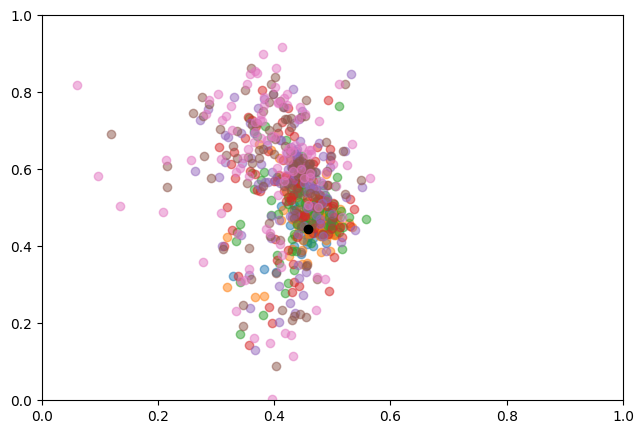

In [146]:
plt.rcParams['figure.figsize'] = [7.5, 5]
for i, ball_positions in enumerate(ball_positions_in_lookahead.values()):
    lookahead_data = pd.DataFrame(ball_positions, columns=['ballx', 'bally'])
    plt.scatter(lookahead_data['ballx'], lookahead_data['bally'], c=f'C{i}', alpha=0.5)
plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

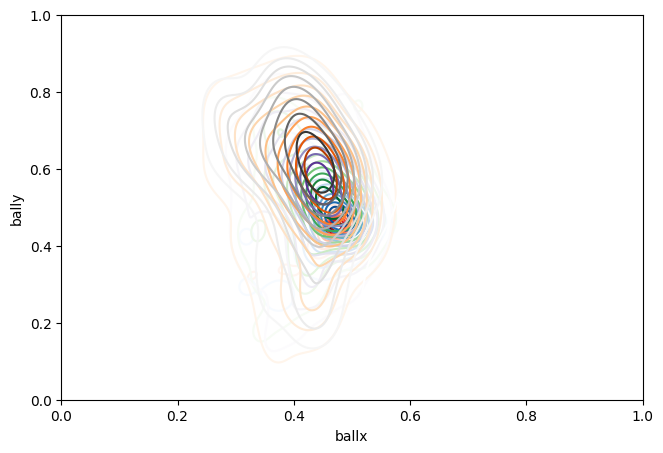

In [144]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [7.5, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys']
for i, ball_positions in enumerate(list(ball_positions_in_lookahead.values())[:6]):
    lookahead_data = pd.DataFrame(ball_positions, columns=['ballx', 'bally'])
    sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

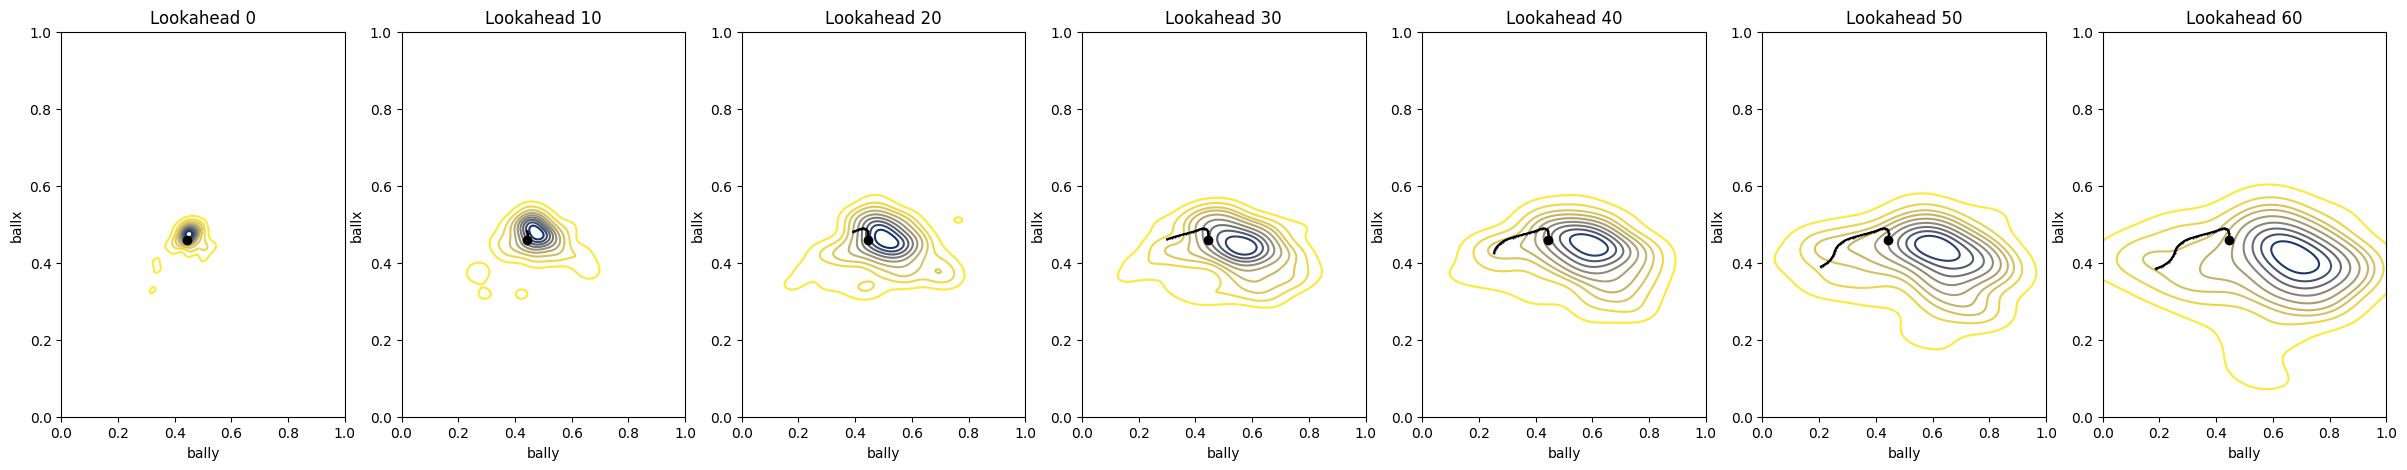

In [153]:
plt.rcParams['figure.figsize'] = [30, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys', 'pink', 'copper', 'bone', 'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'cividis', 'twilight', 'twilight_shifted', 'hsv', 'viridis', 'plasma', 'inferno', 'magma']
n_lookaheads = len(list(ball_positions_in_lookahead.values()))
for i, ball_positions in enumerate(list(ball_positions_in_lookahead.values())):
    plt.subplot(1, n_lookaheads, i+1)
    plt.title(f'Lookahead {i * 10}')
    lookahead_data = pd.DataFrame(ball_positions, columns=['ballx', 'bally'])
    sns.kdeplot(x=lookahead_data['bally'], y=lookahead_data['ballx'], cmap='cividis_r')
    plt.scatter(play_data.iloc[0]['bally'], play_data.iloc[0]['ballx'], c='black', zorder=10)
    plt.plot(play_data.iloc[:10*i]['bally'], play_data.iloc[:10*i]['ballx'], color='black', marker='.', markersize=1)
    plt.xlim(0, 1);
    plt.ylim(0, 1);

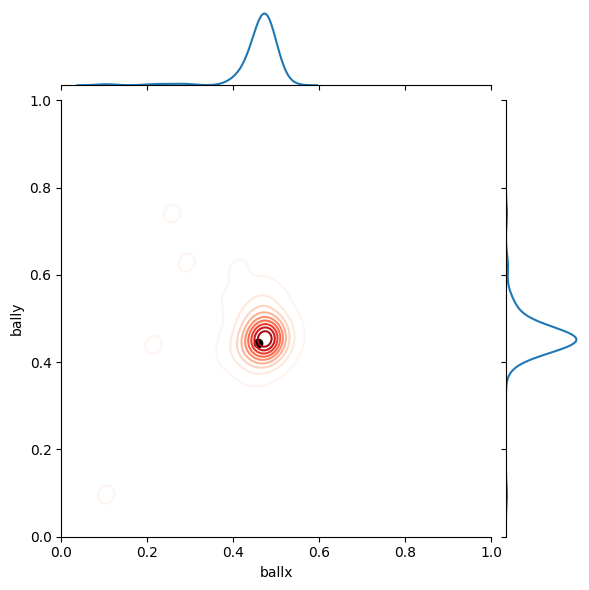

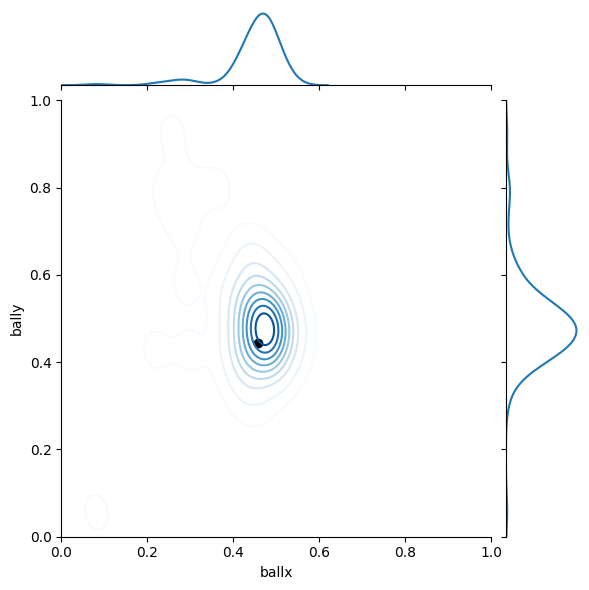

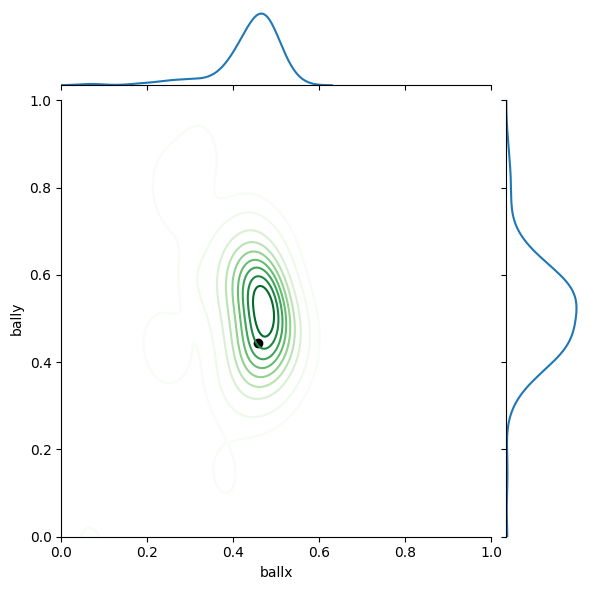

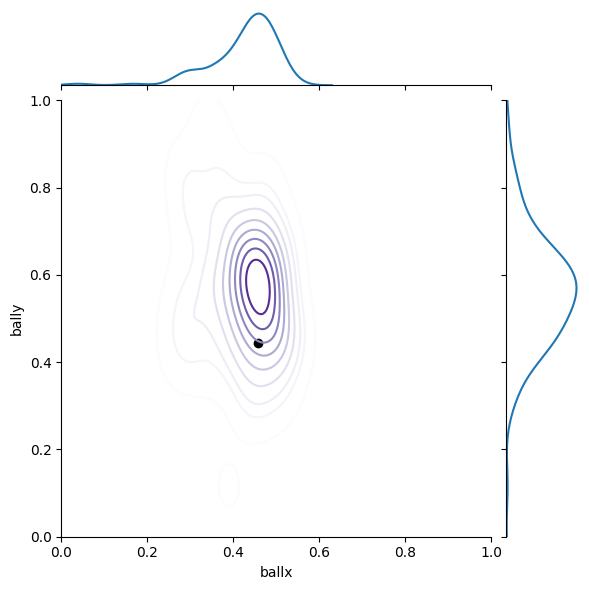

In [ ]:
plt.rcParams['figure.figsize'] = [30, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples']
for i, ball_positions_in_lookahead in enumerate([ball_positions_in_lookahead_10, ball_positions_in_lookahead_20, ball_positions_in_lookahead_30, ball_positions_in_lookahead_40]):
    # plt.subplot(1, 4, i+1)
    lookahead_data = pd.DataFrame(ball_positions_in_lookahead, columns=['ballx', 'bally'])
    sns.jointplot(data=lookahead_data, x="ballx", y="bally", kind="kde", cmap=cmaps[i])#hue="species", 
    # sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'])
    plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
    plt.xlim(0, 1);
    plt.ylim(0, 1);

In [ ]:
current_frame = play_data.iloc[0][features].values
x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
mu, sigma, pi = model(x)
mu.flatten()

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
current_frame.round(4)

array([ 7.100e-01,  5.561e-01,  7.429e-01,  5.538e-01,  7.348e-01,
        5.644e-01,  7.584e-01,  5.178e-01,  7.449e-01,  5.388e-01,
        7.529e-01,  5.398e-01,  7.582e-01,  5.514e-01,  7.641e-01,
        5.313e-01,  7.495e-01,  6.195e-01,  7.387e-01,  5.842e-01,
        7.701e-01,  5.133e-01,  7.453e-01,  5.955e-01,  6.802e-01,
        5.388e-01,  6.898e-01,  5.632e-01,  6.818e-01,  4.567e-01,
        6.784e-01,  6.218e-01,  6.917e-01,  6.178e-01,  6.990e-01,
        5.480e-01,  6.739e-01,  4.698e-01,  6.872e-01,  5.462e-01,
        6.662e-01,  5.062e-01,  6.642e-01,  6.201e-01,  6.778e-01,
        5.685e-01,  0.000e+00,  0.000e+00, -1.100e-03,  0.000e+00,
       -1.700e-03, -8.000e-04, -2.000e-04, -4.500e-03, -9.000e-04,
       -8.000e-04, -4.000e-04, -4.100e-03,  4.000e-04,  8.000e-04,
        2.000e-04, -1.900e-03, -1.200e-03,  3.000e-03, -1.600e-03,
        8.000e-04,  3.000e-04, -7.100e-03, -1.600e-03,  1.900e-03,
       -9.000e-04,  1.100e-03, -2.000e-04,  1.300e-03, -7.000e

In [ ]:
sigma.flatten()

tensor([0.0043, 0.0058, 0.0017, 0.0018, 0.0034, 0.0051, 0.0058, 0.0072, 0.0011,
        0.0020, 0.0034, 0.0046, 0.0014, 0.0028, 0.0012, 0.0022, 0.0026, 0.0062,
        0.0031, 0.0065, 0.0010, 0.0015, 0.0020, 0.0046, 0.0488, 0.0151, 0.0039,
        0.0088, 0.0011, 0.0024, 0.0071, 0.0071, 0.0009, 0.0020, 0.0064, 0.0088,
        0.0194, 0.0060, 0.0010, 0.0023, 0.0057, 0.0045, 0.0072, 0.0080, 0.0404,
        0.0194, 0.0011, 0.0021, 0.0038, 0.0033, 0.0017, 0.0024, 0.0015, 0.0024,
        0.0226, 0.0131, 0.0009, 0.0016, 0.0042, 0.0065, 0.0022, 0.0043, 0.0089,
        0.0152, 0.0009, 0.0014, 0.0054, 0.0087, 0.0140, 0.0077, 0.0011, 0.0023,
        0.0085, 0.0098, 0.0014, 0.0019, 0.0013, 0.0024, 0.0074, 0.0075, 0.0018,
        0.0030, 0.0020, 0.0024, 0.0013, 0.0023, 0.0029, 0.0062, 0.0029, 0.0037,
        0.0316, 0.0190, 0.0065, 0.0120, 0.0011, 0.0033, 0.0013, 0.0023, 0.0052,
        0.0075, 0.0014, 0.0028, 0.0014, 0.0025, 0.0046, 0.0063, 0.0015, 0.0021,
        0.0012, 0.0026, 0.0019, 0.0037, 

In [ ]:
mu.flatten().detach().cpu().numpy() - current_frame.round(4)

ValueError: operands could not be broadcast together with shapes (138,) (184,) 